<a href="https://colab.research.google.com/github/arnoldjames98/arnoldjames98.github.io/blob/main/systemDynamicsAll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Biodegradable Seed Spreading Robot](https://arnoldjames98.github.io/)

# System Dynamics I

### 1. Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.


**Table I. Mechanism Lengths**

| Length | Rigid Body | Measurement (m)
| --- | --- | --- |
| L10 | Yellow | 0.03 |
| L02 | Purple | 0.0689 |
| L42 | Purple | 0.0973 |
| L40 | Purple | 0.0737 |
| L31 | Red | 0.066 |
| L61 | Red | 0.1236 | 
| L63 | Red | 0.0584 |
| L54 | Green | 0.0579 |
| L32 | Orange | 0.0359 |
| L56 | Blue | 0.1004 |
| L5E | Blue | 0.1940 |
| LE6 | Blue | 0.1004 |

**Table II. Mechanism Masses**

| Rigid Body | Mass (kg)
| --- | --- |
| Yellow | 0.000179 |
| Purple | 0.00144 |
| Red | 0.000746 |
| Green | 0.000347 |
| Orange | 0.000215 |
| Blue | 0.00120 |

*Note: The derivation of these mass values is included in the code below. It is based on the weight of cardstock paper.*

Show plots inline and ensure that pynamics is installed.

In [ ]:
%matplotlib inline
!pip install pynamics

     |████████████████████████████████| 92kB 4.0MB/s 


Import all required packages. Packages related to dynamics are commented out since they are not needed for this assignment, but will be used in the future.

In [ ]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body # New for this assignment
from pynamics.dyadic import Dyadic # New for this assignment
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle # New for this assignment
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
from pynamics.constraint import Constraint # New for this assignment
import scipy.optimize

Create a pynamics system where the mechanism is located.

In [ ]:
system = System()
pynamics.set_system(__name__,system)

Declare all length constants and ground coordinate locations.

In [ ]:
# All lengths converted to meters from the previous assignment
# Put all meaured lengths in meters in a list so that if we chose to change these
# in the future, they can all be scaled up or down with a single multiplier
allLengths = [0.03, 0.066, 0.0359, 0.068877, 0.12363, 0.1004, 0.0579, 0.073736, \
              0.0584, 0.0973, 0.1004, 0.19396]

groundCoords = [-0.066, -0.0197, -0.026, 0.069]

lengthScale = 1 # Default is 1, means that the measurements in allLengths and groundCoords will be unchanged from above

# Python's fancy way of scaling each element in the list
allLengths = [x * lengthScale for x in allLengths]
groundCoords = [x * lengthScale for x in groundCoords]

# From Loop Closure Eq. #1
l_10 = Constant(allLengths[0],'l_10',system)
l_31 = Constant(allLengths[1],'l_31',system)
l_32 = Constant(allLengths[2],'l_32',system)
l_02 = Constant(allLengths[3],'l_02',system)

# From Loop Closure Eq. #2
#l_10 already is included in Eq. 1
l_61 = Constant(allLengths[4],'l_61',system)
l_56 = Constant(allLengths[5],'l_56',system)
l_54 = Constant(allLengths[6],'l_54',system)
l_40 = Constant(allLengths[7],'l_54',system)

# Other lengths
l_63 = Constant(allLengths[8],'l_63',system)
l_42 = Constant(allLengths[9],'l_42',system)

# End effector
l_E6 = Constant(allLengths[10],'l_E6',system)
l_5E = Constant(allLengths[11],'l_5E',system)

# Moved the coordinates of the ground link here since they need to be scaled
# the same has lengths
# Ground link coordinates
p2_x = Constant(groundCoords[0],'p2_x',system)
p2_y = Constant(groundCoords[1],'p2_y',system)
p4_x = Constant(groundCoords[2],'p4_x',system)
p4_y = Constant(groundCoords[3],'p4_y',system)

# Consider adding the constant angle constraints in the future

Declare all masses of the links

In [ ]:
# Found some masses by estimating the length/perimeters in m of the different links in Cree's prototype
# This means the "triangular links" are not considered as rigid bodies, but inside just the sides matter
# Note that the blue and red triangular links actually only include 2 of the three sides in Cree's prototype
allMasses = [0.0300, 0.0359, 0.0579, 0.1244, 0.2004, 0.2399]

# Assuming we use 300 g/m2 heavy cardstock and all links are about 0.02m width by the length
# 0.3 kg * 0.02 m = 0.006 kg * m
massScale = 0.006 # Converts the length or perimeter based mass estimates a more realistic value for cardstock

# Python's fancy way of scaling each element in the list
allMasses = [x * massScale for x in allMasses]

print("Link Masses:", allMasses)

mY = Constant(allMasses[0],'mY',system) # Mass of yellow input link
mO = Constant(allMasses[1],'mO',system) # Mass of orange link
mG = Constant(allMasses[2],'mG',system) # Mass of green link
mR = Constant(allMasses[3],'mR',system) # Mass of red link
mB = Constant(allMasses[4],'mB',system) # Mass of blue link
mP = Constant(allMasses[5],'mP',system) # Mass of purple groundlink

Link Masses: [0.00017999999999999998, 0.0002154, 0.0003474, 0.0007464, 0.0012024, 0.0014394]


Define forces in Newtons

In [ ]:
# Gravity in SI units
g = Constant(9.81,'g',system)

# The stiffness and damping are both zero for the first simulation in this report
b = Constant(0,'b',system)
k = Constant(0,'k',system)



---


### 2. Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame. You may use particles for now if you are not sure of the inertial properties of your bodies, but you should plan on finding these values soon for any “payloads” or parts of your system that carry extra loads (other than the weight of paper).

#### First, defining the inertias

In [ ]:
# Diagonal entries of the interia matricies
# For rectangular links, I think something like: https://www.google.com/search?q=inertia+matrix+of+rectangle&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiskPO74YHvAhXwITQIHa09C7QQ_AUoAXoECBMQAw&biw=1440&bih=764#imgrc=pdWYree46q8xbM
# Where diagonal elements are (1/12 * mass * (lengthSideY^2 - lengthSideZ^2) for example
# The triangular links are bit trickier. I think we can do it in SolidWorks
# Note that the frames are defined in the sections below, but are important for 
# identifying which dimension is x (along frame), y (orthogonal to frame), or z (out of the page)

# TODO: Update these diagonal intertia matrix elements based on the geometry of Cree's prototype

# Inertia of yellow link (rectangle) w.r.t Y frame
Ixx_Y = Constant(1,'Ixx_Y',system)
Iyy_Y = Constant(1,'Iyy_Y',system)
Izz_Y = Constant(1,'Izz_Y',system)

# Inertia of orange link (rectangle)
Ixx_O = Constant(1,'Ixx_O',system)
Iyy_O = Constant(1,'Iyy_O',system)
Izz_O = Constant(1,'Izz_O',system)

# Inertia of green link (rectangle)
Ixx_G = Constant(1,'Ixx_G',system)
Iyy_G = Constant(1,'Iyy_G',system)
Izz_G = Constant(1,'Izz_G',system)

# Inertia of red link (two sides of triangle)
Ixx_R = Constant(1,'Ixx_R',system)
Iyy_R = Constant(1,'Iyy_R',system)
Izz_R = Constant(1,'Izz_R',system)

# Inertia of blue link (two sides of triangle)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)

# Inertia of purple link (three sides of triangle)
Ixx_P = Constant(1,'Ixx_P',system)
Iyy_P = Constant(1,'Iyy_P',system)
Izz_P = Constant(1,'Izz_P',system)

#### NOTE: Some additionally code from the kinematics assignment is needed to define the frames, since the center of masses require that the frames be defined.

Create the differentiable state variables, cooresponding to the joint angles (we might not need all of these depending on how we do the constraints)

In [ ]:
# Note: All angles are measured CCW

# Input state variable (angle of crank on yellow link)
qY,qY_d,qY_dd = Differentiable('qY',system) # Yellow input link, measured from base frame coordinates

# Other state variables (angles of the four undefined links)
# Note that the purple link is ground so is fully defined
qO,qO_d,qO_dd = Differentiable('qO',system) # Orange link w.r.t base frame
qG,qG_d,qG_dd = Differentiable('qG',system) # Green link w.r.t base frame

# Links defined w.r.t non-ground link (not connected to ground)
qR,qR_d,qR_dd = Differentiable('qR',system) # Red link w.r.t yellow link frame
qB,qB_d,qB_dd = Differentiable('qB',system) # Blue link w.r.t green link frame

Initial guess for starting positions

In [ ]:
# TODO: We can measure the angles on our directly from our figure to make some guesses
initialvalues = {}
# Yellow link w.r.t base
initialvalues[qY]=130*pi/180 #130*pi/180 (positive) is the input for which I estimated the other angles
initialvalues[qY_d]=0

# Orange link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qO]=130*pi/180
initialvalues[qO_d]=0

# Green link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qG]=160*pi/180
initialvalues[qG_d]=0

# Red link w.r.t yellow link frame
initialvalues[qR]=30*pi/180
initialvalues[qR_d]=0

# Blue link w.r.t green link frame
initialvalues[qB]=60*pi/180
initialvalues[qB_d]=0

Retrieve state variables in the order they are stored in the system

In [ ]:
# Not sure if we need this, but it's included in the tutorial
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

Create the main reference frames, with one cooresponding to each rigid link

In [ ]:
N = Frame('N') # Purple (ground) link

# Defined w.r.t to ground
Y = Frame('Y') # Yellow
O = Frame('O') # Orange
G = Frame('G') # Green

# Defined w.r.t to other links 
# Note that both are directed towards p6
# Important since this is how the angle representing the link is defined
R = Frame('R') # Red w.r.t yellow
B = Frame('B') # Blue w.r.t green

# Helpful additional frames for triangular links
# These frames define the constant angles within the triangular joints
R_to_p3 = Frame('R_to_p3') # Red w.r.t yellow (+ constant degrees to align x-axis with p3)
B_to_pE = Frame('B_to_pE') # Blue w.r.t green (+ constant degrees to align x-axis with pE)
B_plus_180 = Frame('B_plus_180') # Blue with x axis in opposite direction
R_from_p3 = Frame('R_from_p3') # Red rotated so that it can point from p3 to p6 (CW rotation)
B_from_p6 = Frame('B_from_p6') # Blue rotated so it can go from p6 to pE

Declare N as the Newtonian (fixed) frame

In [ ]:
system.set_newtonian(N)

Rotate frames about their z-axes so they align with the correct rigid link.

In [ ]:
# Frames cooresponding to joint angles
Y.rotate_fixed_axis_directed(N,[0,0,1],qY,system) # Yellow
O.rotate_fixed_axis_directed(N,[0,0,1],qO,system) # Orange
G.rotate_fixed_axis_directed(N,[0,0,1],qG,system) # Green
R.rotate_fixed_axis_directed(Y,[0,0,1],qR,system) # Red w.r.t yellow
B.rotate_fixed_axis_directed(G,[0,0,1],qB,system) # Blue w.r.t green

# Helpful frames for triangular joints
# 6.007 degrees from B frame to align axis with p3
R_to_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR+6.007*pi/180,system) # Red w.r.t yellow
# 15 degrees from B frame to align axis with pE
B_to_pE.rotate_fixed_axis_directed(G,[0,0,1],qB+15*pi/180,system) # Blue w.r.t green
# B plus 180 (this comes in handy later when defining a vector in the opposite direction)
B_plus_180.rotate_fixed_axis_directed(G,[0,0,1],qB+180*pi/180,system) # Blue reversed
# R - 5.84 degrees (CW rotation) from p3 to p6
R_from_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR-12.8*pi/180,system) # Red w.r.t yellow
# Rotate B frame 30 degrees CCW to go from p6 to pE
B_from_p6.rotate_fixed_axis_directed(G,[0,0,1],qB+30*pi/180,system)

#### Now with the frames defined, the **center of masses** can be considered

In [ ]:
# Vectors representing the joint locations w.r.t N frame
# Fixed points on purple (ground) link
p0 = 0*N.x # P0 is at the origin
p2 = p2_x*N.x + p2_y*N.y # Coordinates given (in meters)
p4 = p4_x*N.x + p4_y*N.y # Coordinates given (in meters)

# Note that for all other points, they are still w.r.t N frame, but they can be defined from different directions/pathways
# Defining the same point from different directions/pathways is needed for constraints
# Points directly connected to ground
p1_from_p0 = p0 + l_10*Y.x
p3_from_p2 = p2 + l_32*O.x
p5_from_p4 = p4 + l_54*G.x

# Additional points (Consider alternative defnitions of these)
p6_from_p1 = p1_from_p0 + l_61*R.x
pE_from_p5 = p5_from_p4 + l_5E*B_to_pE.x # 15 degrees CCW from B frame x axis

# Alternate pathways to points (used to make LHS and RHS of loop equations defined differently)
p3_from_p1 = p1_from_p0 + l_31*R_to_p3.x # 6.007 degrees (CCW) from R frame x axis
p5_from_p6 = p6_from_p1 + l_56*B_plus_180.x # 180 degress (CCW) from B frame x axis
p6_from_p3 = p3_from_p2 + l_63*R_from_p3.x # -5.84 degress (CW) from R frame x axis
pE_from_p6 = p6_from_p3 + l_E6*B_from_p6.x

# List of points to that will be used for plotting 
# Doesn't matter which version of points like p1 we use since they will be constrained to be equal
points = [p0, p1_from_p0, p2, p3_from_p2, p4, p5_from_p4, p6_from_p1, pE_from_p6]

# Alternative list that works will with Dr. Aukes's plotting function
#points = [p0,p1_from_p0,p3_from_p1,p2,p4,p5_from_p4,p6_from_p1,pE_from_p6,p6_from_p1,p3_from_p1]

In [ ]:
# Center of mass for each link, requires information about frames
# For the triangular links, we will need to consider both the x and y components
# since the COM will not be located along any frame like for the straight joints where it is in the middle
# These ones are easy: just in the middle of the length along the correct frame
cmY= l_10/2*Y.x
cmO= p2+l_32/2*O.x
cmG= p4+l_54/2*G.x

# These ones need x and y components (Estimated based on solidworks)
# Note that in the future if dimensions change these need to be updated
cmR=p1_from_p0+0.06*R.x-0.01*R.y
cmB=p5_from_p4+0.08*B.x+0.03*B.y
cmP=-0.05*N.x+0.06*N.y

The next several lines compute the inertia dyadics of each body and define a rigid body on each frame.

In [ ]:
# Define the intertia w.r.t to the appropriate frames
IY = Dyadic.build(Y,Ixx_Y,Iyy_Y,Izz_Y)
IO = Dyadic.build(O,Ixx_O,Iyy_O,Izz_O)
IG = Dyadic.build(G,Ixx_G,Iyy_G,Izz_G)
IR = Dyadic.build(R,Ixx_R,Iyy_R,Izz_R)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IP = Dyadic.build(N,Ixx_P,Iyy_P,Izz_P) # Purple link is in Newtonian frame

# Define the bodies that describe the mass/inertial properties of each link
BodyY = Body('BodyY',Y,cmY,mY,IY,system)
BodyO = Body('BodyO',O,cmO,mO,IO,system)
BodyG = Body('BodyG',G,cmG,mG,IG,system)
BodyR = Body('BodyR',R,cmR,mR,IR,system)
BodyB = Body('BodyB',B,cmB,mB,IB,system)
BodyP = Body('BodyP',N,cmP,mP,IP,system)

# An alternative approach is to represent each mass as a particle at a certain point
#BodyC = Particle(pCcm,mC,'ParticleC',system)



---


### 3. Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint. You do not need to add external motor/spring forces but you should start planning to collect that data.

#### **NOTE: We decided to include a constant torque input to the system, so that we could better show the gait of the crab mechanism. Therefore, our system does not fall down like a rag doll, but does spin. We talked to Dr. Aukes at office hours about this.**

Stiffness pre-loads are set to reasonable values for the various joint angles. Note that in this section it is not important since k is set to 0.

In [ ]:
# Stiffness equilibrium (where joint naturally wants to be) for each joint
# We will need to update the angles with ones that make sense based on how the paper joints are folded
preloadY = Constant(130*pi/180,'preload0',system)
preloadO = Constant(130*pi/180,'preload1',system)
preloadG = Constant(160*pi/180,'preload2',system)
preloadR = Constant(30*pi/180,'preload3',system)
preloadB = Constant(60*pi/180,'preload4',system)

Adding the forces: note that in this section damping and stiffness are 0, so only the input torque and gravity cause changes to the system dynamics

In [ ]:
#Angular velocity brought from Triple Pendulum
#angular velocity between frames N and Y, Y and O , and O and G
wY = N.getw_(Y)
wR = Y.getw_(R)
wO = N.getw_(O)
wG = N.getw_(G)
wB = G.getw_(B)

system.addforce(1*N.z,wY)
system.addforcegravity(-g*N.y)
system.addforce(-b*wY,wY)

# In the future, we'll need to think more about which of these we need
system.add_spring_force1(k,(qY-preloadY)*N.z,wY) 
system.add_spring_force1(k,(qO-preloadO)*N.z,wO)
system.add_spring_force1(k,(qG-preloadG)*N.z,wG)
system.add_spring_force1(k,(qR-preloadR)*Y.z,wR)
system.add_spring_force1(k,(qB-preloadB)*G.z,wB)

(<pynamics.force.Force at 0x7fb856414890>,
 <pynamics.spring.Spring at 0x7fb85648e750>)



---


### 4. Constraints: Keep mechanism constraints in, but follow the pendulum example of double-differentiating all constraint equations.
*   If you defined your mechanism as unattached to the Newtonian frame, add enough constraints so that it is fully attached to ground (for now). you will be eventually removing these constraints.


Create a list of initial values ini0 in the order of the system’s state variables

In [ ]:
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

Create all the vector equation constraints (e.g., loop closure equations, rigid link constraints, etc.)

In [ ]:
# Loop closure equations (constraint to ensure all loops are equal to zero)
# Equation 1 (R02 + R10 + R31 = R32)
loopClosure1 = p3_from_p1 - p3_from_p2

# Equation 2 (R10 + R61 + R56 = R40 + R54)
loopClosure2 = p5_from_p4 - p5_from_p6

Convert the vector constraints into scalar equations that can be solved

In [ ]:
eq = [] # Initialize

# Loop closure equations
eq.append((loopClosure1).dot(N.x))
eq.append((loopClosure1).dot(N.y))

eq.append((loopClosure2).dot(N.x))
eq.append((loopClosure2).dot(N.y))

# Show the equations
print(eq)

# Take the derivatives
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d] # Added for this assignment

# Show the derivatives
print(eq_d)

[l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299) - l_32*cos(qO) - p2_x, l_10*sin(qY) + l_31*sin(qY)*cos(qR + 0.104841928167299) + l_31*sin(qR + 0.104841928167299)*cos(qY) - l_32*sin(qO) - p2_y, -l_10*cos(qY) + l_54*cos(qG) + l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979) + l_61*sin(qR)*sin(qY) - l_61*cos(qR)*cos(qY) + p4_x, -l_10*sin(qY) + l_54*sin(qG) - l_56*sin(qG)*cos(qB + 3.14159265358979) - l_56*sin(qB + 3.14159265358979)*cos(qG) - l_61*sin(qR)*cos(qY) - l_61*sin(qY)*cos(qR) + p4_y]
[l_32*qO_d*sin(qO) + qR_d*(-l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY)) + qY_d*(-l_10*sin(qY) - l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY)), -l_32*qO_d*cos(qO) + qR_d*(-l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299)) + qY_d*(l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR

Solve for a valid initial condition

In [ ]:
qi = [qY] # Yellow link is the input
qd = [qO, qG, qR, qB] # All other links are dependent on the input
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)
eq = [item.subs(constants) for item in eq]
error = (numpy.array(eq)**2).sum()
f = sympy.lambdify(qd,error)

def function(args):
  return f(*args)
guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
print("Tolerance:", result.fun)

ini = []

for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

#points = PointsOutput(points, constant_values=system.constant_values)
#points.calc(numpy.array([ini0,ini]))

Tolerance: 3.517101411278203e-09




---


### 5. Solution: Add the code from the bottom of the pendulum example for solving for f=ma, integrating, plotting, and animating. Run the code to see your results. It should look similar to the pendulum example with constraints added, as in like a rag-doll or floppy

In [ ]:
f,ma = system.getdynamics()
#Solving for Acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

2021-02-28 19:02:49,563 - pynamics.system - INFO - getting dynamic equations
2021-02-28 19:02:50,013 - pynamics.system - INFO - solving a = f/m and creating function
2021-02-28 19:02:50,016 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-02-28 19:02:50,650 - pynamics.system - INFO - done solving a = f/m and creating function
2021-02-28 19:02:50,651 - pynamics.system - INFO - calculating function for lambdas


Adding Integration code

In [ ]:
#insert code here, some code copied and pasted from pendulum example
tol = 1e-12
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]
# Note: important to input a valid initial condition
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-02-28 19:02:53,490 - pynamics.integration - INFO - beginning integration
2021-02-28 19:02:53,494 - pynamics.system - INFO - integration at time 0000.00
2021-02-28 19:02:54,315 - pynamics.system - INFO - integration at time 0003.94
2021-02-28 19:02:55,097 - pynamics.system - INFO - integration at time 0005.96
2021-02-28 19:02:55,876 - pynamics.system - INFO - integration at time 0007.48
2021-02-28 19:02:56,666 - pynamics.system - INFO - integration at time 0008.67
2021-02-28 19:02:57,462 - pynamics.system - INFO - integration at time 0009.86
2021-02-28 19:02:57,628 - pynamics.integration - INFO - finished integration


#### Plotting and Animation

Create a figure that shows how the state variables evolve over the time of the simulation. In other words, plot how are the links rotating over time.

<Figure size 432x288 with 0 Axes>

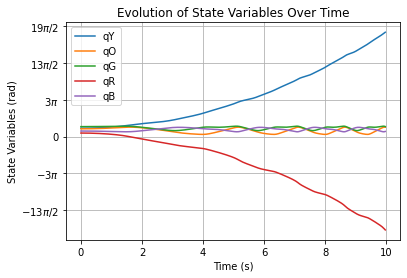

In [ ]:
plt.figure()
f,ax=plt.subplots(1)
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['yellow', 'orange', 'g', 'r', 'b']) +
                           cycler('linestyle', ['-', '-', '-', '-', '-'])))
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("State Variables (rad)")
artists = plt.plot(t,states[:,:5])
plt.title('Evolution of State Variables Over Time')

plt.legend(artists,['qY','qO','qG','qR','qB'])

# Function from https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
# Used to make tick marks show in units of pi
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(numpy.round(2 * value / numpy.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

# Makes the tick marks show units of pi
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

Prepare an animation of the mechanism's motion and show some of the frames

2021-02-28 19:03:09,068 - pynamics.output - INFO - calculating outputs
2021-02-28 19:03:09,091 - pynamics.output - INFO - done calculating outputs


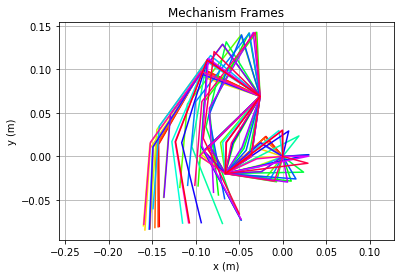

In [ ]:
# Make the colors make cycle through a large variety to show each frame
plt.rc('axes', prop_cycle=(plt.cycler('color', plt.cm.hsv(numpy.linspace(0, 1, fps)))))

points_output = PointsOutput(points,system)
y = points_output.calc(states)

points_output.plot_time(tfinal)
plt.title('Mechanism Frames')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

Plot an animation of the mechanism

In [ ]:
# Plots final frame of Animation and created object that is used for animation
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,1,1),linestyle='-') #produces animation using matplotlib
plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.close() # Hide the plot that just shows a single frame of the animation

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

Creating a more easy to read animation (note: this code takes a long time to run. It creates an easier to understand animation, but does not provide any new information from the plot above)

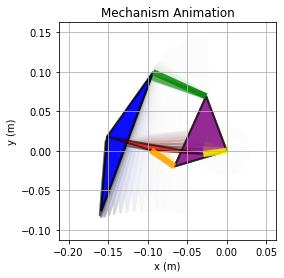

In [ ]:
from matplotlib.animation import FuncAnimation

def animate(i):
    # Hacky way to not show show every frame (semitransparent whitebox colors over old frames)
    white = plt.fill([-0.2, -0.2, 0.05, 0.05], [ -0.1, 0.15, 0.15, -0.1], facecolor='white', alpha=0.3)
    # Blue link
    blueLink = plt.fill([y[i][7,0],  y[i][6,0],  y[i][5,0]], [ y[i][7,1],  y[i][6,1],  y[i][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Blue link
    blueLink = plt.fill([y[i][7,0],  y[i][6,0],  y[i][5,0]], [ y[i][7,1],  y[i][6,1],  y[i][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Purple link
    purpleLink = plt.fill([ y[i][0,0],  y[i][2,0],  y[i][4,0]], [ y[i][0,1],  y[i][2,1],  y[i][4,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
    # Red link
    redLink = plt.fill([ y[i][1,0],  y[i][3,0],  y[i][6,0]], [ y[i][1,1],  y[i][3,1],  y[i][6,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
    # Orange link
    orangeLink = plt.fill([ y[i][2,0],  y[i][3,0]], [ y[i][2,1],  y[i][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
    # Green link
    greenLink = plt.fill([ y[i][4,0],  y[i][5,0]], [ y[i][4,1],  y[i][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
    # Yellow link
    yellowLink = plt.fill([ y[i][0,0],  y[i][1,0]], [ y[i][0,1],  y[i][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)
    plt.axis('scaled')
    
    return blueLink

fig, ax = plt.subplots()

plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

anim = FuncAnimation(fig, animate, frames=t.size, interval=tstep*1000, blit=True)
HTML(anim.to_html5_video())



---


### 6. Tuning: Now adjust the damper value `b` to something nonzero, that over 10s shows that the system is settling.

Set the damping is now set to a non-zero value (note that there is still an input torque to the system)

In [ ]:
b = Constant(3,'b',system)
system.addforce(-b*wY,wY)
f,ma = system.getdynamics()

#Solving for Acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-02-28 19:03:16,175 - pynamics.system - INFO - getting dynamic equations
2021-02-28 19:03:16,606 - pynamics.system - INFO - solving a = f/m and creating function
2021-02-28 19:03:16,610 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-02-28 19:03:17,113 - pynamics.system - INFO - done solving a = f/m and creating function
2021-02-28 19:03:17,115 - pynamics.system - INFO - calculating function for lambdas
2021-02-28 19:03:17,118 - pynamics.integration - INFO - beginning integration
2021-02-28 19:03:17,121 - pynamics.system - INFO - integration at time 0000.00
2021-02-28 19:03:17,548 - pynamics.integration - INFO - finished integration


Plot states over time

<Figure size 432x288 with 0 Axes>

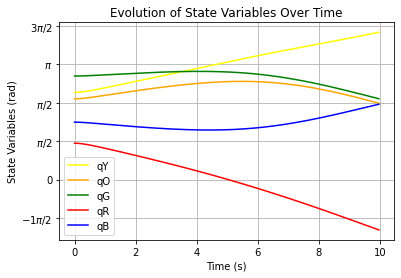

In [ ]:
plt.figure()
f,ax=plt.subplots(1)
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['yellow', 'orange', 'g', 'r', 'b']) +
                           cycler('linestyle', ['-', '-', '-', '-', '-'])))
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("State Variables (rad)")
artists = plt.plot(t,states[:,:5])
plt.title('Evolution of State Variables Over Time')

plt.legend(artists,['qY','qO','qG','qR','qB'])

# Function from https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
# Used to make tick marks show in units of pi
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(numpy.round(2 * value / numpy.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

# Makes the tick marks show units of pi
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

Plot overlaying multiple animation frames

2021-02-28 03:33:43,956 - pynamics.output - INFO - calculating outputs
2021-02-28 03:33:43,976 - pynamics.output - INFO - done calculating outputs


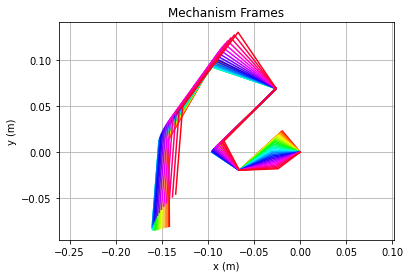

In [ ]:
# Make the colors make cycle through a large variety to show each frame
plt.rc('axes', prop_cycle=(plt.cycler('color', plt.cm.hsv(numpy.linspace(0, 1, fps)))))

points_output = PointsOutput(points,system)
y = points_output.calc(states)

points_output.plot_time(tfinal)
plt.title('Mechanism Frames')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

Pynamics animation

In [ ]:
# Plots final frame of Animation and created object that is used for animation
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,1,1),linestyle='-') #produces animation using matplotlib
plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.close() # Hide the plot that just shows a single frame of the animation

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

Color coded animation

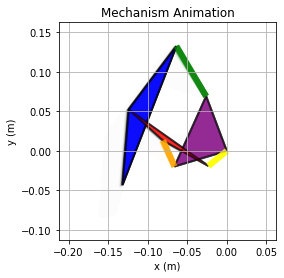

In [ ]:
fig, ax = plt.subplots()

plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

anim = FuncAnimation(fig, animate, frames=t.size, interval=fps, blit=True)
HTML(anim.to_html5_video())



---


### 7. (Optional): Adjust joint stiffness values so that your system looks more realistic.

In [ ]:
# Set the stiffness to a non-zero value
# Note that the damping is still present in the system
k = Constant(1,'k',system)

# Note that the pre-loads were defined previously and set to reasonable values
system.add_spring_force1(k,(qY-preloadY)*N.z,wY) 
system.add_spring_force1(k,(qO-preloadO)*N.z,wO)
system.add_spring_force1(k,(qG-preloadG)*N.z,wG)
system.add_spring_force1(k,(qR-preloadR)*Y.z,wR)
system.add_spring_force1(k,(qB-preloadB)*G.z,wB)

f,ma = system.getdynamics()

# Solving for Acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-02-28 03:37:13,364 - pynamics.system - INFO - getting dynamic equations
2021-02-28 03:37:13,655 - pynamics.system - INFO - solving a = f/m and creating function
2021-02-28 03:37:13,662 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-02-28 03:37:14,119 - pynamics.system - INFO - done solving a = f/m and creating function
2021-02-28 03:37:14,120 - pynamics.system - INFO - calculating function for lambdas
2021-02-28 03:37:14,122 - pynamics.integration - INFO - beginning integration
2021-02-28 03:37:14,124 - pynamics.system - INFO - integration at time 0000.00
2021-02-28 03:37:14,443 - pynamics.integration - INFO - finished integration


<Figure size 432x288 with 0 Axes>

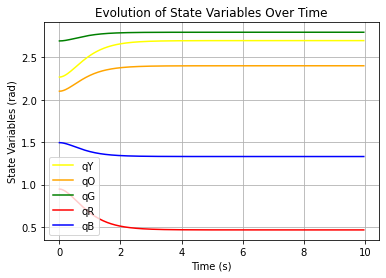

In [ ]:
plt.figure()
f,ax=plt.subplots(1)
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['yellow', 'orange', 'g', 'r', 'b']) +
                           cycler('linestyle', ['-', '-', '-', '-', '-'])))
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("State Variables (rad)")
artists = plt.plot(t,states[:,:5])
plt.title('Evolution of State Variables Over Time')

plt.legend(artists,['qY','qO','qG','qR','qB'])

# Function from https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
# Used to make tick marks show in units of pi
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(numpy.round(2 * value / numpy.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

# Makes the tick marks show units of pi
# For some reason, there is an error in this situation
# I think it's related to the very small range of angles
#ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

2021-02-28 03:37:14,753 - pynamics.output - INFO - calculating outputs
2021-02-28 03:37:14,772 - pynamics.output - INFO - done calculating outputs


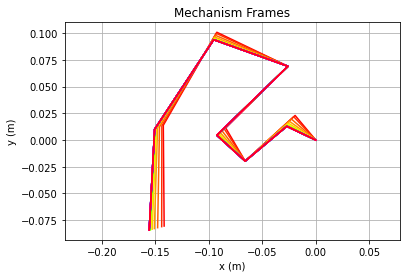

In [ ]:
# Make the colors make cycle through a large variety to show each frame
plt.rc('axes', prop_cycle=(plt.cycler('color', plt.cm.hsv(numpy.linspace(0, 1, fps)))))

points_output = PointsOutput(points,system)
y = points_output.calc(states)

points_output.plot_time(tfinal)
plt.title('Mechanism Frames')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

In [ ]:
# Plots final frame of Animation and created object that is used for animation
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,1,1),linestyle='-') #produces animation using matplotlib
plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.close() # Hide the plot that just shows a single frame of the animation

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

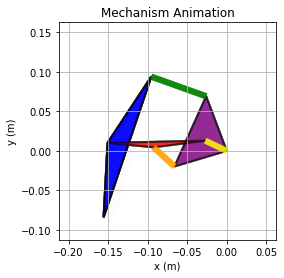

In [ ]:
fig, ax = plt.subplots()

plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

anim = FuncAnimation(fig, animate, frames=t.size, interval=fps, blit=True)
HTML(anim.to_html5_video())



---


# System Dynamics II Plan



We decided as a group to use a thin cardboard material as our main material for creating our biodegradable robot.

### Break-up Data Collection/Prototyping

| Goal | Team Member |
| --- | --- |
| Identify damping parameter for cardboard material | Daniel |
| Identify stiffness parameter for cardboard material | Cree, Katie |
| Build first system level prototype | James |

### To Do After Experiments/Prototyping
*   Add stiffness and damping to joints p2, p4, and p5
  *   James, Daniel: where to input stiffness and damping
  *   Daniel: add damping value you found
  *   Cree and Katie: Add stiffness (from calculation of young’s modulus)

*   Add ground reaction force (spring/damper connected to pE for ground)
  *   Katie, Daniel

*   Justify not disconnecting ground link from the base frame
  *   James, Cree

*   Add more reasonable torque estimate at input
  *   James




---


# System Dynamics II Prep (Individual Parameter ID)

## Daniel: Damping Characterization

In order to solve for the dampening of one of the joints of the system I set up the test experiment as detailed in the tracker tutorial. After cutting up the pieces of cardboard that are being used, they were set up as seen below.

![damping](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/damping.PNG)


I lifted the joint up to be parallel with the table and then released the joint while recording. I then used the tracker software to track where the joint traveled over time. The distance between the two calibration points were 6.75 inches while the distance from the camera was 12 inches. I converted these measurements to meters before inputting them into the tracker software. As desired, this system created a dampened oscillation as can be seen below which was gathered from the data collected from the tracker.

![oscillation](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/oscillation.PNG)


I could then calculate the damping constant from this oscillation using the following equations [1].

Td=time/number of oscillations=(3.9-2.74)/4=0.29
d=2/Td=2/0.29=21.66
=1/n*ln(X0/Xn)=1/5ln(0.0164/0.00228)=0.394
=/(42+2)0.5=0.0626

The damping constant that was found was a value of 0.0626. 
Lastly, the data was extracted and interpolated which was done by using Daniel Aukes’ code as found below. The graphs that were obtained are also detailed below as well as the raw data that is included.


![extrapolation](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/extrapolated.PNG)


### -*- CODE-*-
"""
Created on Wed Mar  3 13:54:15 2021

@author: danaukes
"""

import pandas as pd
import numpy
import matplotlib.pyplot as plt
import scipy.interpolate as si

df=pd.read_csv(r'D:\Daniel Files\School\EGR 557\data.csv', sep=',')

x = df.x.to_numpy()
y = df.y.to_numpy()
t = df.t.to_numpy()


xy = numpy.array([x,y]).T
f = si.interp1d(t,xy.T,fill_value='extrapolate',kind='quadratic')
new_t = numpy.r_[0:t[-1]:.1]

plt.figure()
plt.plot(t,x)
plt.plot(new_t,f(new_t)[0])

plt.figure()
plt.plot(t,y)
plt.plot(new_t,f(new_t)[1])
plt.figure()
plt.plot(x,y)


## Cree: FEA Analysis and Cantilever Experiment

### SolidWorks FEA

To create the FEA analysis in SolidWorks, I followed the steps provided by Dr. Aukes for SolidWorks simulation for FEA analysis [1]. When selecting the material, I had to create custom material for the one my team is going to be using. Since cardboard is not a material that is in SolidWorks, I did some research to find the material properties of it. For Elastic Modulus, I used a paper from the University of Orleans in France to get 5106.67 MPa [2]. For Poisson’s Ratio, I used a paper from the Journal of Applied Packaging Research to find 0.33 [3]. Mass density was calculated using 0.69 g/cm^3 from [4] to get 0.02489 lb/in^3. Figures 1 and 2 show the FEA analysis from vonMises and Displacement.

![vonMises](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/Cantilever/vonMises.png)

![Displacement](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/Cantilever/Displacement.png)

### Cantilever Beam Experiment

For this experiment, my team and I split up the tasks. I did the FEA Analysis and the experiment while one of my other teammates does two beam tests on their own, the code portion of the experiment, and the Euler-Bernoulli Beams code. The reason was the team had already assigned the tasks this way before the page was reformatted.

I used a kitchen scale to weigh each of the 5 objects I used for the experiments. I did not have calibrated weights and these were the best I could come up with around my house.

![Button](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/Cantilever/Button.jpg)

![FlashDrive](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/Cantilever/Flash%20Drive.jpg)

![Scissors](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/Cantilever/Scissors.jpg)

![Earbuds](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/Cantilever/Earbuds.jpg)

![Scissors+Earbuds](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/Cantilever/Scissors%2BEarbuds.jpg)

After weighing each of the objects, I cut each piece of material to the dimensions of 25mmx125mm as indicated in the assignment. Next, I labeled each piece and measured its thickness in two places. I used a rubber band for hanging the weights because I did not have string around. I took pictures of each test for all 3 bottom beams and measured the deflections. I used a caliper to measure the deflection of the beams. Unfortunately, I did not have a tripod to take pictures from the same position each time, however, I did try to keep it consistent. Below is what each test looked like and the full sheet of data for the experiment.


![Tests](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/Cantilever/Rigid/Collage1.png)

![Data](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/Cantilever/FullData.jpg)

<h1><center>References</center></h1>

[1] 	D. M. Aukes, "Solidworks FEA Tutorial: Foldable Robotics," [Online]. Available: 
https://egr557.github.io/modules/compliance/solidworks-fea-tutorial.html.. [Accessed 4 
March 2021].

[2] 	S. Allaoui, Z. Aboura and M. Benzeggagh, "CONTRIBUTION TO THE MODELLING
OF THE CORRUGATED," [Online]. Available: 
https://arxiv.org/ftp/arxiv/papers/1110/1110.5417.pdf. [Accessed 4 March 2021].

[3] 	T. Fadiji, T. Berry, C. Coetzee and U. L. Opara, "Investigating the Mechanical Properties
of Paperboard Packaging Material for Handling Fresh Produce Under Different 
Environmental Conditions: Experimental Analysis and Finite Element Modelling," 
Journal of Applied Packaging Research. 

[4] 	aqua-calc, "Density of Cardboard (material)," [Online]. Available: 
https://www.aqua-calc.com/page/density-table/substance/cardboard#:~:text=Density%20
of%20Cardboard%20(material)&text=Cardboard%20weighs%200.689%20gram%20per,i
nch%20%5Boz%2Finch%C2%B3%5D%20.. [Accessed 4 March 2021].


## Cree and Katie: Stiffness Characterization

In [ ]:
# TODO: Paste individual assigment here. 
# You may need to upload videos to youtube to link them and upload pictures to Github to link them

## James: System Level Prototype

**Goal**: Create a system-level prototype used to evaluate the validity of our team’s concept.

Some of the main questions our team currently has for creating the full system are:
*   How will we manufacture our robot so that it is fully biodegradable?
*   How will we rotate multiple Klann Linkage mechanisms simultaneously given one input actuator?
*   How will we power our robot? (Originally, we had considered using a balloon to spin a turbine, but I am going to suggest here that we instead rely on the outside air.)


### Manufacturing

The first step I took was to figure out how to fabricate multiple legs (I decided to make four since this is the minimum required for the crab gait to work properly) with the same dimensions. Each Klann Linkage mechanism requires five total links, with one stationary link that in previous assignments we have referred to as the ground link. First, I made a prototype of a single leg with cardstock as shown below:

![Paper Prototype](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/paperPrototype.jpg)

I was able to improve on our previous single leg prototypes by adding additional material on the rigid joints that are not straight. I used a protractor to measure the appropriate angles and this added material prevents unwanted rotation at these folds. This prototype also demonstrated that the ground link cannot but a rigid triangle, since it interferes with the rotation of the orange link in the figure below (from the kinematics assignment):

![Mechanism Drawing - Lengths](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/frames.png) 

Note that the prototype aims to use folding joints for all the joints besides the input, yellow link. This input link is not included in the folding mechanism, since it requires periodic rotational motion that cannot be achieved by a single folding joint. Therefore, a wheel and axel mechanism will be used for the input link which will be shown later in this assignment.

With this new iteration of the folding Klann linkage mechanism designed, the next step became how to create four of these legs. The legs need to all have the same dimensions, and ideally, they do not use material than is necessary. For example, the purple ground link can be used for two legs that are adjacent to one another. So, a piece of thin cardboard (the same material being considered by all group members for their individual assignments this week) was used to draw out all the necessary links and plan out all the cuts and folds. 

![Cut Plan Cardboard](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/cutPlanCardboard.jpg) 

Care was taken to get the dimensions correct, and the angle supports were measured using a protector. This could be optimized to minimize the number of cuts required, but the repeated links (since multiple legs are being made at once) are somewhat tessellated together with the goal of minimizing cuts. Next, the cardboard was cut out:

![Cut Plan Cardboard](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/cutOut.jpg) 

With all the links cut out and labeled, the next step was to begin assembling the legs. The first step in the assembly was to add the additional material used for the non-straight links. This step of the assembly is show below:

![Cut Plan Cardboard](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/cutOut2.jpg) 

Note that regular scotch tape was used as an adhesive. While this is not biodegradable, biodegradable tape exists and can be used for the final design. Next, the four legs are assembled. As mentioned previously, adjacent legs can use the same ground link:

![Legs](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/legs.jpg) 

Now, the four folded Klann linkage mechanisms are all fully assembled. While improvements can be made in order to minimize the number of cuts required to create four legs at once, this prototyping exercised helped demonstrate how this task can be done and improved upon in the future.

### Rotating All Leg Mechanisms Simultaneously

The next question that has not yet been answered for our team is how we can rotate multiple of these mechanisms at once, and ideally using a single actuator as an input so that all legs rotated simultaneously. I believe that using a gears is a good option for our group, since gears can be used convert the input of a single rotational actuator to rotations at each of the input links of the folding Klann linkages. Gears could also be made out of biodegradable material. I think a dense cardboard material or wood would be our best option. For the purposes of prototyping the full system, I used plastic gears from a kids toy set that I had at home.

First, I attempted to rotate two legs simultaneously with gears, and a picture of this set up is shown below:


![Legs](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/legsWithGears.jpg) 

Note how an additional support is added that connects the two ground linkages together and also suspends the ground linkages in the correct locations with respect to the gears. The radius of the gears happened to perfectly match the length of the input link, so pins were attached to each of the outer gears that connected to joint p1, which requires periodic rotation. The pins are currently metal but could be replaced with a biodegradable wood material (e.g., toothpicks) in the future. A video of this mechanism moving two of the four legs can be seen at:

In [ ]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/gI_PB2JJ0C0?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

The next step was to rotate the other set of legs that are not being actuated in the previous set-up. The middle gear is used as a way to connect another parallel set of three gears that rotate simultaneously. The structure holding the ground linkages in place had to be changed slightly to prevent an interference with the connector for the middle gears. An additional input gear was also added so that it was clear which gear represents the input to the system. Multiple views of this prototype that can actuate all four legs simultaneously are shown below:

![Prototype Views](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/systemPrototype.png) 

Note that the red gears (from the previous version of the prototype) are connected to the blue gears (the new additions to this fully actuated prototype) by a plastic connection so that the middle gears of each set of three rotate together. The large yellow gear at the top rotates the blue gears, which in turn also rotates the red gears. The outer gears of the red and blue sets of gears each have a single pin at on the circumference of the gear that turns acts as the input to each of folded Klaan linkage mechanisms.

A video showing the input gear rotating and causing the legs to all move is can be seen at the following link:

In [ ]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/UrNlfwX9GD0?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

As mentioned previously, these plastic gears and supports cannot be used in the final design since they are not biodegradable. Additionally, these gears and supports weigh far too much to be supported by the cardboard legs, so this prototype cannot walk. However, with a light material and smaller supports, the robot should be able to walk. 

### Powering the Robot

The final question is how to rotate the input gear. While a motor would work well, it would not be biodegradable. For this reason, we had considered using a balloon to rotate a turbine in the past. However, a balloon would need to be very large and have a very controlled release of air for this to work for any practical application. Therefore, I am proposing in this assignment that we instead rely on wind power from the environment. While this means our robot would only work if there is wind, I think that this is a reasonable for a seed spreading robot that must be made fully out of biodegradable materials. For testing purposes for future assignments, we could use a motor so wind is not required, or we could use a blow drier or fan to simulate wind. 

My idea is to use a pinwheel to harvest wind power that can rotate the input gear. A pinwheel can be easily created from a biodegradable paper material and could even be considered a foldable energy generation method. I created a basic pinwheel out of cardstock and attached to a gear that can then rotate the input gear. A video of a pinwheel I made with cardstock rotating the input gear (with air input to the pinwheel from a ceiling fan) can be seen at the following link:


In [ ]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/FyguxYbtsFA?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

While the pinwheel was able to generate enough torque to rotate the input gear by itself, it did not generate enough torque to power the full system. I believe that if the gear ratio were optimized and support structure for the Klann Linkages were made more precise, this method would work. The full prototype with the pinwheel connected to the input gear can be seen in the following images: 

![Prototype Views](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/systemPrototype2.png) 

Overall, this full system prototype demonstrated that our fully biodegradable crab robot could be made, but it will require many considerations such as:
*  The selection of materials and what scale is small enough to be light, but large enough that it is manufacturable with home supplies. 
  *  The gears should be made out of a rigid material like wood, the pins could also be wood. The support structure could be cardboard or wood. Making the gears spin without friction may be difficult. Every new material added to the system is also something that should be considered, since adding different materials adds complexity to the manufacturing of the robot.
*  The size of the pinwheel mechanism and the gear ratio that best optimizes the torque required by the system.
  *  I believe using a larger gear for the pin wheel could help increase our torque to the legs. I couldn’t figure out a way to easily get a desirable gear ratio with the kids gears I had at home.
*  Whether or not we should try to make the design fully biodegradable given the number of materials we would need to purchase and the complexity in the fabrication of the gear mechanism.
*  How to design the full system so it can be supported by the legs. 
*  How to select the initial conditions for each of the input links on the Klann mechanism to best support gait.
  *  In this prototype I offset the opposing legs with the goal of always having 2 legs in contact with the ground at any given time. However, an even number of gears in each set (like the blue and red set in this prototype) may be required for the legs to promote motion in the same direction.
*  Where to place markers for preforming motion capture analysis.




---


# System Dynamics II

The point of this assignment is to re-consolidate everything we have learned about our system back into our dynamic model. It now includes:

*   **At least one “compliant” element**: we have added the compliance of our three folding joints in the mechanism
*   **All unknown parameters determined and included**: we characterized the stiffness and damping of our selected material (thin cardboard)
*   **Joint or system-level damping determined**: the experimental stiffness and damping calculations are presented in this report
*   **An actuator model or stored energy source**: an experiment was performed to characterize our input wind turbine and gear mechanism
*   **Ground constraints considered**: we decided to not disconnect our ground link from the base frame, and we have included our justification in this report
*   **Valid initial condition**: we have maintained our code for finding a valid intial condition based on the kinematic constraints.
*   **Energy Plot**: we have added code to turn off the motor halfway through the simulation to verify that the energy in the system settles to zero when no energy is input to the system via the motor.

### Progress Made since System Dynamics I

A number of important tasks were performed last week by indivually by separate members of the team. Our main goal was to experimentally test how our robot will be built so that we could add more information to our dynamics model.

#### Selection of a Compliant Element

To determine which elements should be modeled with compliance, we needed to figure out which joints in our mechansism would be made by folding material, and which joints would need to be taped or need to allow for full rotation. Therefore, we needed to create a system level prototype to understand how we could make the Klaan linkage mechanism using foldable robots techniques.

In the following video, a video of a system level prototype of the robot can be seen. This prototype is too heavy to by supported by the legs since a gear mechanism was made with somewhat heavy plastic gears, however, this prototype shows how the Klaan Mechanism was made using foldable techniques, and shows the most up-to-date prototype. In this prototype, all the links in the Klaan linkage mechanism were cut out separately and then taped together as needed, but from this prototyping exercise, it was much easier to identify which joints could be replaced by folding the material itself rather than using tape.

In [ ]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/UrNlfwX9GD0?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

As mentioned previously, all of the joints in the mechanism were made by either taping together pieces of carboard (so the tape material is what is defining the compliance of the joints) or a rotating wheel and axel joint had to be used. A full diagram of the mechanism can be seen in the figure below. Note that this is the same diagram used in previous assignments, except that the triangular links are replaced by just two sides of the triangular link. While prototyping the full system, it was clear that not all three sides of the trianglular links were necessary, however there is no change in any of the measurements or kinematics of the mechanism. In our first iteration of the full system prototype, we used perpendicular pieces of carboard to constrain our non-straight links such as the blue, red, and purple links. 

![Mechanism Drawing - Updated](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/updatedDiagram.png)

We characterized the stiffness and damping of our cardboard material, so we need to determine which joints will be made out of this cardboard material with folding hinges. Since there are multiple interconnected loops (four bar and a five bar loop), there is not a way to make all the joints foldable without introducing undesireable complexity. For example, consider p6 on the diagram above. Material is required along LE6, L56, and L63, and these three components cannot be easily created with a foldable joint, but taping the red link to the blue link can be done very easily. However, taping all the joints is not necessary (consider p5, where a simple fold provides the desired effect).

Therefore, one of our goals in this assignment is to identify which joints can be easily manufactured using foldable technqiues and then add the compliance of the material at these joints. There are many different places where compliance could be considered (within the cardboard links, at the taped joints), but the folded joints are of the highest importance for future work on the manufacturing of our prototype. Additionally, it is possible that optimizing the stiffness at these foldable joints could improve our robot's gait, so it is a good candidate for a part of our model to add compliance to.

From the creation of our system level prototype, we identified three main joints can can be made by folding our cardboard material: p5, p4, and p2. These joints were identified by planning out the required folds and cuts for the next iteration of our prototype where we do not cut out each link individually. A diagram showing the planned cuts, folds, and how the links will be attached is included below:

![Mechanism Foldable Design](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/foldCutPlan2.png)

Note that the colors on this diagram are used to match the colors on previous diagrams of the mechansim. In the prototype, two Klaan Linkage mechanisms are attached to the purple ground link, but just one is shown here for simplicity. In this diagram, the blue, green, purple, and orange links can all be created by cutting out a single piece of cardboard. While dashed lines indicate locations on the cardboard that are folded, and sectors are shown above the folds that will be constrainted to be rigid using a perpendicular piece of cardboard (as can be seen in the video of the prototype). The red link is cut as a separate piece that can be taped to the main foldable part of the mechanism, and the red link is also attached to a pin connected to a wheel with a radius equal to the length of the "yellow link." From this diagram, the seven joints defining the mechansim (p0-p6) are characterized to show what material they will be made out of.


**Table I. Mechanism Lengths**

| Joint | Material/Method | Justification
| --- | --- | --- |
| p0 | Rotating Axel | Input to the system must allow periodic rotation so cannot be made with a foldable hinge |
| p1 | Rotating Axel | Also must allow periodic rotation |
| p2 | Cardboard Fold | Easiest method is folding |
| p3 | Taped | Located on separate red link |
| p4 | Cardboard Fold | Easiest method is folding |
| p5 | Cardboard Fold | Easiest method is folding | 
| p6 | Taped | Located on separate red link |


Therefore, p2, p4, and p5 will be considered to be made out of the same material as the links. The impedance properties of this material has been characterized, and the values found experimentally will be added to the model. Future work could consider modeling the taped hinges or the bending within the links, but we decided modeling the folable hinges in the cardboard would be the most important. Additionally, the stiffness of this hinges can be tuned adding or removing material from the joints, so it presents a full defined optimization problem for future work in improving the robot's gait. A diagram indicating the foldable joints on the main foldable piece of cardboard is shown below:

![Mechanism Foldable Design 2](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/foldCutPlan3.png)

We decided that the compliance within the joints would be the most important to add to the model. We considered adding compliance to the links too, since the stiffness experiment was based on the bending of the material. However, our goal was not to add compliance to every element in our model, and we believe the joint compliance will be the most important in understanding our mechanism. The stiffness experiment was used to characterize the Young's modulus of the material, and then this value was used to model the stiffness at joints p2, p4, and p5. The damping experiment value was based on the folded carboard so this value could be used directly.

#### Stiffness Charaterization

First the Solidworks FEA was created to show the behavior of our selected material when load is applied. The first image is the vonMises Analysis while Displacement is the second. Next, the Cantilever Beam experiment was performed to show in real time how different materials would bend under stress. Deflection was recorded when each weight was placed on the beam. One example of the experiment is shown in the third image with the scissors. From here, Young's Modulus was calculated for each of the different weights for the rigid material. After Young's Modulus was calculated, it was used to calculate and model the stiffness for the blue link (p2, p4, and p5) that touches the ground, since those joints will be made out of cardboard.
![Mechanism Drawing - Updated](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/vonMises.png)
![Mechanism Drawing - Updated](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/Displacement.png)
![Mechanism Drawing - Updated](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/CantileverExperiment.jpg)

Code for Stiffness

slope:  0.009673636363636363


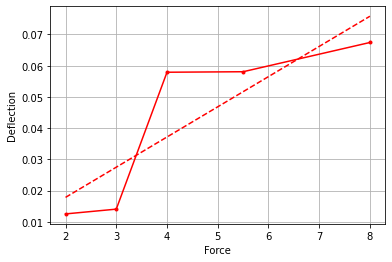

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import sympy
import numpy as np
from sympy import pi
from sympy import integrate
import pandas as pd
from scipy.stats import linregress

b,h,theta,P,L,E,I,x,w,M,q,p,A,B,C,D,p0,M0=sympy.symbols('b,h,theta,P,L,E,I,x,w,M,q,p,A,B,C,D,p0,M0')

x_axis = [2, 3, 4, 5.5, 8] # mass of various loads (oz)
xt = np.array(x_axis)
y_axis = [0.0125, 0.01403, 0.0579, 0.05806, 0.06743] # deflection numbers for rigid cardboard (m)
yt = np.array(y_axis)
slope, intercept, r_value, p_value, std_err = linregress(x_axis, y_axis)
def a_predict(x_axis):
    return intercept + slope*x_axis

x_min, x_max = min(x_axis), max(x_axis)
a_min, a_max = a_predict(x_min), a_predict(x_max)

plt.plot(xt, intercept + slope*xt, 'r--')

print("slope: ", slope)
plt.plot(x_axis, y_axis, '.r-')
plt.xlabel('Force')
plt.ylabel('Deflection')
plt.grid(True)
plt.show()



In [ ]:
def plot_x(w,subs1=None):
    subs1 = subs1 or {}
    w = w.subs(subs1) 
    unit = dict([(item,1) for item in w.atoms(sympy.Symbol) if item!=x])
    unit.update(subs1)
    w_num = w.subs(unit)
    f_w = sympy.lambdify(x,w_num)

    xn = np.r_[0:unit[L]:100j]
    yn = f_w(xn)

    plt.plot(xn,yn)
    plt.axis('equal')

In [ ]:
#Computed moment of beam as function of the loading 
b = 0.125 # meters
h = 0.025 # meters
Ixx = (1/12)*b*h**3
Iyy = (1/12)*h*b**3
MaxDeflect = [0.0125, 0.01403, 0.0579, 0.05806, 0.06743]
d = np.array(MaxDeflect)
P = [2, 3, 4, 5.5, 8]
p = np.array(P)
E = ((b**3)*p)/(d * 3*(Ixx))
E2 = ((b**3)*4.5)/(0.041984 * 3*(Ixx)) # 4.5 and 0.041984 are the average weight and deflection respectively
rounded = np.round(E, 2)
print("Young's Modulus:\n", rounded)
rounded2 = np.round(E2, 2)
print("Average Young's Modulus:\n", rounded2)
Stiffness = E2 * Ixx
print("Stiffness:\n", Stiffness)
M_dd = np.dot(p, p) 

Young's Modulus:
 [640000.   855310.05 276338.51 378918.36 474566.22]
Average Young's Modulus:
 428734.76
Stiffness:
 0.06978104754192073


This value of stiffness was used to add compliance to the joints that will be made out of the cardboard material.

#### Damping Characterization 

In order to solve for the dampening of one of the joints of the system I set up the test experiment as detailed in the tracker tutorial. After cutting up the pieces of cardboard that are being used, they were set up. I lifted the joint up to be parallel with the table and then released the joint while recording. I then used the tracker software to track where the joint traveled over time. The distance between the two calibration points were 6.75 inches while the distance from the camera was 12 inches. I converted these measurements to meters before inputting them into the tracker software. As desired, this system created a dampened oscillation that were gathered from the data collected from the tracker.

I could then calculate the damping constant from this dampened oscillation using the following equations.

Td=time/number of oscillations=(3.9-2.74)/4=0.29
d=2/Td=2/0.29=21.66
=1/n*ln(X0/Xn)=1/5ln(0.0164/0.00228)=0.394
=/(42+2)0.5=0.0626

The damping constant that was found was a value of 0.0626. 
Lastly, the data was extracted and interpolated which was done by using Aukes’ code as found below. We were then able to use this value add compliance to the joints that will be made out of the cardboard material.








#### Energy Source and Actuator Charaterization

In [ ]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/FyguxYbtsFA?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

The main unknown about this wind turbine mechanism is how much torque it can produce at the input link to the Klaan mechanism. An experiment was performed to find the stall torque of the motor, which represents the maximum torque that the power source can produce. A portable room fan was used to simulate the windy conditions required for the wind turbine to spin. Then weight was added a string attached to the input gear. As the gear spun, the radius of the winding would increase until the point when the torque caused by the weight would cause the mechanism to stall. This method was selected by following the instructions at the following link: https://scienceprog.com/easy-way-to-measure-motor-torque/. A video of the experiment when suffient weight (pencils tied to the end of the string) caused the wind turbine "motor" to stall.

In [ ]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/bqz16L2NnmQ?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

Then, the weight (29 g) and winding radius (1.75cm) were measured as shown in the image below:
![Torque Experiment](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/torqueExp.png)

Finally, the torque output of the mechansims could be calculated as follows: torque = (0.029 kg)(0.0175 m)(9.81 m/s^2) = 0.00498 Nm. Note that this value is extremely close to the value estimated that was required for the crab in the [*Biomechanics Background and Initial Specifications*](https://arnoldjames98.github.io/assignment2) assignment of 0.00513 Nm. Therefore, we will use 0.00498 Nm as the estimated constant input torque for this assignment. In the full system prototype, additional gears of the same gear ratio were connected to the gear that the above experiment was performed on. This implies that the current wind turbine design may only provide enough torque to move a single leg, meaning that our power source will likely need to be updated in the future.

#### Disconnecting Ground Link from Base Frame

We have decided to not remove the ground/purple link from the base frame since removing it would greatly complicate our dynamic model. Disconnecting the ground link from the base frame would require considerations on how the other legs of the robot support the robot during locomotion. Without the other legs of the robot supporting the robot, a dynamic model of a single leg disconnected from the ground would just fall over since there are no other legs supporting the robot. We considered adding additional constraints to the single leg model to prevent the leg from tipping over, but setting these constraints correctly would be highly dependent on how the ground/purple link will move during locomotion (i.e., the gait of the crab and weight of the body would affect how the ground/purple link moves over time). Modeling a single leg grounded allows us to still model the compliance and ground reaction effects of the robot moving, so we believe this is a reasonable modeling assumption.

#### Additional Improvements to Dynamics Model



*   We have added a floor constraint so we can model the effect of the crab's leg hitting the ground. A justification for the stiffness/damping values used to simulate the collision are included within the code below.





---



### Improved Dynamics Model

Since the prototype was built to scale, none of the mechanism lengths are changed from the previous assignment.


**Table I. Mechanism Lengths**

| Length | Rigid Body | Measurement (m)
| --- | --- | --- |
| L10 | Yellow | 0.03 |
| L02 | Purple | 0.0689 |
| L42 | Purple | 0.0973 |
| L40 | Purple | 0.0737 |
| L31 | Red | 0.066 |
| L61 | Red | 0.1236 | 
| L63 | Red | 0.0584 |
| L54 | Green | 0.0579 |
| L32 | Orange | 0.0359 |
| L56 | Blue | 0.1004 |
| L5E | Blue | 0.1940 |
| LE6 | Blue | 0.1004 |

**Table II. Mechanism Masses**

| Rigid Body | Mass (kg)
| --- | --- |
| Yellow | 0.000179 |
| Purple | 0.00144 |
| Red | 0.000746 |
| Green | 0.000347 |
| Orange | 0.000215 |
| Blue | 0.00120 |

*Note: The derivation of these mass values is included in the code below. It is based on the weight of cardstock paper.*

Show plots inline and ensure that pynamics is installed.

In [ ]:
%matplotlib inline
!pip install pynamics

     |████████████████████████████████| 92kB 699kB/s 


Import all required packages. Packages related to dynamics are commented out since they are not needed for this assignment, but will be used in the future.

In [ ]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body # New for this assignment
from pynamics.dyadic import Dyadic # New for this assignment
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle # New for this assignment
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
from pynamics.constraint import Constraint # New for this assignment
import scipy.optimize

Create a pynamics system where the mechanism is located.

In [ ]:
system = System()
pynamics.set_system(__name__,system)

Declare all length constants and ground coordinate locations.

In [ ]:
# All lengths converted to meters from the previous assignment
# Put all meaured lengths in meters in a list so that if we chose to change these
# in the future, they can all be scaled up or down with a single multiplier
allLengths = [0.03, 0.066, 0.0359, 0.068877, 0.12363, 0.1004, 0.0579, 0.073736, \
              0.0584, 0.0973, 0.1004, 0.19396]

groundCoords = [-0.066, -0.0197, -0.026, 0.069]

lengthScale = 1 # Default is 1, means that the measurements in allLengths and groundCoords will be unchanged from above

# Python's fancy way of scaling each element in the list
allLengths = [x * lengthScale for x in allLengths]
groundCoords = [x * lengthScale for x in groundCoords]

# From Loop Closure Eq. #1
l_10 = Constant(allLengths[0],'l_10',system)
l_31 = Constant(allLengths[1],'l_31',system)
l_32 = Constant(allLengths[2],'l_32',system)
l_02 = Constant(allLengths[3],'l_02',system)

# From Loop Closure Eq. #2
#l_10 already is included in Eq. 1
l_61 = Constant(allLengths[4],'l_61',system)
l_56 = Constant(allLengths[5],'l_56',system)
l_54 = Constant(allLengths[6],'l_54',system)
l_40 = Constant(allLengths[7],'l_54',system)

# Other lengths
l_63 = Constant(allLengths[8],'l_63',system)
l_42 = Constant(allLengths[9],'l_42',system)

# End effector
l_E6 = Constant(allLengths[10],'l_E6',system)
l_5E = Constant(allLengths[11],'l_5E',system)

# Moved the coordinates of the ground link here since they need to be scaled
# the same has lengths
# Ground link coordinates
p2_x = Constant(groundCoords[0],'p2_x',system)
p2_y = Constant(groundCoords[1],'p2_y',system)
p4_x = Constant(groundCoords[2],'p4_x',system)
p4_y = Constant(groundCoords[3],'p4_y',system)

# Consider adding the constant angle constraints in the future

Declare all masses of the links

In [ ]:
# Found some masses by estimating the length/perimeters in m of the different links in Cree's prototype
# This means the "triangular links" are not considered as rigid bodies, but inside just the sides matter
# Note that the blue and red triangular links actually only include 2 of the three sides in Cree's prototype
allMasses = [0.0300, 0.0359, 0.0579, 0.1244, 0.2004, 0.2399]

# Assuming we use 300 g/m2 heavy cardstock and all links are about 0.02m width by the length
# 0.3 kg * 0.02 m = 0.006 kg * m
massScale = 0.006 # Converts the length or perimeter based mass estimates a more realistic value for cardstock

# Python's fancy way of scaling each element in the list
allMasses = [x * massScale for x in allMasses]

print("Link Masses:", allMasses)

mY = Constant(allMasses[0],'mY',system) # Mass of yellow input link
mO = Constant(allMasses[1],'mO',system) # Mass of orange link
mG = Constant(allMasses[2],'mG',system) # Mass of green link
mR = Constant(allMasses[3],'mR',system) # Mass of red link
mB = Constant(allMasses[4],'mB',system) # Mass of blue link
mP = Constant(allMasses[5],'mP',system) # Mass of purple groundlink

Link Masses: [0.00017999999999999998, 0.0002154, 0.0003474, 0.0007464, 0.0012024, 0.0014394]


Define forces in Newtons

In [ ]:
# Gravity in SI units
g = Constant(9.81,'g',system)

# Experimentally found value for damping
b = Constant(0.0626,'b',system)

# Experimentally found value for stiffness, estimated based on experimentally found Young's Modulus
k = Constant(Stiffness,'k',system)

#### First, defining the inertias

In [ ]:
# Diagonal entries of the interia matricies
# For rectangular links: https://www.google.com/search?q=inertia+matrix+of+rectangle&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiskPO74YHvAhXwITQIHa09C7QQ_AUoAXoECBMQAw&biw=1440&bih=764#imgrc=pdWYree46q8xbM
# Where diagonal elements are (1/12 * mass * (lengthSideY^2 - lengthSideZ^2) for example
# The triangular links are bit trickier. I think we can do it in SolidWorks
# Note that the frames are defined in the sections below, but are important for 
# identifying which dimension is x (along frame), y (orthogonal to frame), or z (out of the page)

# TODO: Update these diagonal intertia matrix elements based on the geometry of Cree's prototype

# Inertia of yellow link (rectangle) w.r.t Y frame
Ixx_Y = Constant(1,'Ixx_Y',system)
Iyy_Y = Constant(1,'Iyy_Y',system)
Izz_Y = Constant(1,'Izz_Y',system)

# Inertia of orange link (rectangle)
Ixx_O = Constant(1,'Ixx_O',system)
Iyy_O = Constant(1,'Iyy_O',system)
Izz_O = Constant(1,'Izz_O',system)

# Inertia of green link (rectangle)
Ixx_G = Constant(1,'Ixx_G',system)
Iyy_G = Constant(1,'Iyy_G',system)
Izz_G = Constant(1,'Izz_G',system)

# Inertia of red link (two sides of triangle)
Ixx_R = Constant(1,'Ixx_R',system)
Iyy_R = Constant(1,'Iyy_R',system)
Izz_R = Constant(1,'Izz_R',system)

# Inertia of blue link (two sides of triangle)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)

# Inertia of purple link (three sides of triangle)
Ixx_P = Constant(1,'Ixx_P',system)
Iyy_P = Constant(1,'Iyy_P',system)
Izz_P = Constant(1,'Izz_P',system)

#### NOTE: Some additionally code from the kinematics assignment is needed to define the frames, since the center of masses require that the frames be defined.

Create the differentiable state variables, cooresponding to the joint angles (we might not need all of these depending on how we do the constraints)

In [ ]:
# Note: All angles are measured CCW

# Input state variable (angle of crank on yellow link)
qY,qY_d,qY_dd = Differentiable('qY',system) # Yellow input link, measured from base frame coordinates

# Other state variables (angles of the four undefined links)
# Note that the purple link is ground so is fully defined
qO,qO_d,qO_dd = Differentiable('qO',system) # Orange link w.r.t base frame
qG,qG_d,qG_dd = Differentiable('qG',system) # Green link w.r.t base frame

# Links defined w.r.t non-ground link (not connected to ground)
qR,qR_d,qR_dd = Differentiable('qR',system) # Red link w.r.t yellow link frame
qB,qB_d,qB_dd = Differentiable('qB',system) # Blue link w.r.t green link frame

# New angle for the compliant link#
#qNew,qNew_d,qNew_dd = Differentiable('qNew',system) # In the middle of the blue link

Initial guess for starting positions

In [ ]:
# TODO: We can measure the angles on our directly from our figure to make some guesses
initialvalues = {}
# Yellow link w.r.t base
initialvalues[qY]=130*pi/180 #130*pi/180 (positive) is the input for which I estimated the other angles
initialvalues[qY_d]=0

# Orange link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qO]=130*pi/180
initialvalues[qO_d]=0

# Green link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qG]=160*pi/180
initialvalues[qG_d]=0

# Red link w.r.t yellow link frame
initialvalues[qR]=30*pi/180
initialvalues[qR_d]=0

# Blue link w.r.t green link frame
initialvalues[qB]=60*pi/180
initialvalues[qB_d]=0

# New compliant blue link
#initialvalues[qNew]=30*pi/180
#initialvalues[qNew_d]=0

Retrieve state variables in the order they are stored in the system

In [ ]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

Create the main reference frames, with one cooresponding to each rigid link

In [ ]:
N = Frame('N') # Purple (ground) link

# Defined w.r.t to ground
Y = Frame('Y') # Yellow
O = Frame('O') # Orange
G = Frame('G') # Green

# Defined w.r.t to other links 
# Note that both are directed towards p6
# Important since this is how the angle representing the link is defined
R = Frame('R') # Red w.r.t yellow
B = Frame('B') # Blue w.r.t green

# Helpful additional frames for triangular links
# These frames define the constant angles within the triangular joints
R_to_p3 = Frame('R_to_p3') # Red w.r.t yellow (+ constant degrees to align x-axis with p3)
B_to_pE = Frame('B_to_pE') # Blue w.r.t green (+ constant degrees to align x-axis with pE)
B_plus_180 = Frame('B_plus_180') # Blue with x axis in opposite direction
R_from_p3 = Frame('R_from_p3') # Red rotated so that it can point from p3 to p6 (CW rotation)
B_from_p6 = Frame('B_from_p6') # Blue rotated so it can go from p6 to pE

Declare N as the Newtonian (fixed) frame

In [ ]:
system.set_newtonian(N)

Rotate frames about their z-axes so they align with the correct rigid link.

In [ ]:
# Frames cooresponding to joint angles
Y.rotate_fixed_axis_directed(N,[0,0,1],qY,system) # Yellow
O.rotate_fixed_axis_directed(N,[0,0,1],qO,system) # Orange
G.rotate_fixed_axis_directed(N,[0,0,1],qG,system) # Green
R.rotate_fixed_axis_directed(Y,[0,0,1],qR,system) # Red w.r.t yellow
B.rotate_fixed_axis_directed(G,[0,0,1],qB,system) # Blue w.r.t green

# Helpful frames for triangular joints
# 6.007 degrees from B frame to align axis with p3
R_to_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR+6.007*pi/180,system) # Red w.r.t yellow
# 15 degrees from B frame to align axis with pE
B_to_pE.rotate_fixed_axis_directed(G,[0,0,1],qB+15*pi/180,system) # Blue w.r.t green
# B plus 180 (this comes in handy later when defining a vector in the opposite direction)
B_plus_180.rotate_fixed_axis_directed(G,[0,0,1],qB+180*pi/180,system) # Blue reversed
# R - 5.84 degrees (CW rotation) from p3 to p6
R_from_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR-12.8*pi/180,system) # Red w.r.t yellow
# Rotate B frame 30 degrees CCW to go from p6 to pE

# Note that instead of qB+30 degrees, qNew is now there since we have a compliant joint within the blue link
B_from_p6.rotate_fixed_axis_directed(G,[0,0,1],qB+30*pi/180,system)

#### Now with the frames defined, the **center of masses** can be considered

In [ ]:
# Vectors representing the joint locations w.r.t N frame
# Fixed points on purple (ground) link
p0 = 0*N.x # P0 is at the origin
p2 = p2_x*N.x + p2_y*N.y # Coordinates given (in meters)
p4 = p4_x*N.x + p4_y*N.y # Coordinates given (in meters)

# Note that for all other points, they are still w.r.t N frame, but they can be defined from different directions/pathways
# Defining the same point from different directions/pathways is needed for constraints
# Points directly connected to ground
p1_from_p0 = p0 + l_10*Y.x
p3_from_p2 = p2 + l_32*O.x
p5_from_p4 = p4 + l_54*G.x

# Additional points (Consider alternative defnitions of these)
p6_from_p1 = p1_from_p0 + l_61*R.x
pE_from_p5 = p5_from_p4 + l_5E*B_to_pE.x # 15 degrees CCW from B frame x axis

# Alternate pathways to points (used to make LHS and RHS of loop equations defined differently)
p3_from_p1 = p1_from_p0 + l_31*R_to_p3.x # 6.007 degrees (CCW) from R frame x axis
p5_from_p6 = p6_from_p1 + l_56*B_plus_180.x # 180 degress (CCW) from B frame x axis
p6_from_p3 = p3_from_p2 + l_63*R_from_p3.x # -5.84 degress (CW) from R frame x axis
pE_from_p6 = p6_from_p3 + l_E6*B_from_p6.x

# List of points to that will be used for plotting 
# Doesn't matter which version of points like p1 we use since they will be constrained to be equal
points = [p0, p1_from_p0, p2, p3_from_p2, p4, p5_from_p4, p6_from_p1, pE_from_p6]

# Alternative list that works will with Dr. Aukes's plotting function
#points = [p0,p1_from_p0,p3_from_p1,p2,p4,p5_from_p4,p6_from_p1,pE_from_p6,p6_from_p1,p3_from_p1]

In [ ]:
# Center of mass for each link, requires information about frames
# For the triangular links, we will need to consider both the x and y components
# since the COM will not be located along any frame like for the straight joints where it is in the middle
# These ones are easy: just in the middle of the length along the correct frame
cmY= l_10/2*Y.x
cmO= p2+l_32/2*O.x
cmG= p4+l_54/2*G.x

# These ones need x and y components (Estimated based on solidworks)
# Note that in the future if dimensions change these need to be updated
cmR=p1_from_p0+0.06*R.x-0.01*R.y
cmB=p5_from_p4+0.08*B.x+0.03*B.y
cmP=-0.05*N.x+0.06*N.y

The next several lines compute the inertia dyadics of each body and define a rigid body on each frame.

In [ ]:
# Define the intertia w.r.t to the appropriate frames
IY = Dyadic.build(Y,Ixx_Y,Iyy_Y,Izz_Y)
IO = Dyadic.build(O,Ixx_O,Iyy_O,Izz_O)
IG = Dyadic.build(G,Ixx_G,Iyy_G,Izz_G)
IR = Dyadic.build(R,Ixx_R,Iyy_R,Izz_R)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IP = Dyadic.build(N,Ixx_P,Iyy_P,Izz_P) # Purple link is in Newtonian frame

# Define the bodies that describe the mass/inertial properties of each link
BodyY = Body('BodyY',Y,cmY,mY,IY,system)
BodyO = Body('BodyO',O,cmO,mO,IO,system)
BodyG = Body('BodyG',G,cmG,mG,IG,system)
BodyR = Body('BodyR',R,cmR,mR,IR,system)
BodyB = Body('BodyB',B,cmB,mB,IB,system)
BodyP = Body('BodyP',N,cmP,mP,IP,system)

# An alternative approach is to represent each mass as a particle at a certain point
#BodyC = Particle(pCcm,mC,'ParticleC',system)

#### **NOTE: We decided to include a constant torque input to the system, so that we could better show the gait of the crab mechanism. Therefore, our system does not fall down like a rag doll, but does spin. We talked to Dr. Aukes at office hours about this.**

Stiffness pre-loads are set to reasonable values for the various joint angles. Note that in this section it is not important since k is set to 0.

In [ ]:
# Stiffness equilibrium (where joint naturally wants to be) for each joint
# We will need to update the angles with ones that make sense based on how the paper joints are folded
#preloadY = Constant(130*pi/180,'preload0',system)
#preloadO = Constant(130*pi/180,'preload1',system)
#preloadG = Constant(160*pi/180,'preload2',system)
#preloadR = Constant(30*pi/180,'preload3',system)
#preloadB = Constant(60*pi/180,'preload4',system)

# Assumption: Stiffness equilibirium of folded cardboard is straight
preloadO = Constant(0*pi/180,'preloadO',system)
preloadG = Constant(0*pi/180,'preloadG',system)
preloadB = Constant(0*pi/180,'preloadB',system)

# Stiffness equilibrium of the compliant joint within the blue link
#preloadNew = Constant(30*pi/180,'preload4',system)

Adding the forces: note that in this section damping and stiffness are 0, so only the input torque and gravity cause changes to the system dynamics

The code turns the motor off after 5 seconds to show that the energy of the system decreases to zero due to the added dampening, friction, and compliance of the system.

In [ ]:
#Angular velocity brought from Triple Pendulum
#angular velocity between frames N and Y, Y and O , and O and G
wY = N.getw_(Y)
wR = Y.getw_(R)
wO = N.getw_(O)
wG = N.getw_(G)
wB = G.getw_(B)

#system.addforce(1*N.z,wY)
#shut motor off after 3 seconds
T = system.t-3
T_s = -(T-abs(T))
on = T_s/(2*T)
#motor at input link
#system.addforce(-1*N.z*on,wY)
system.addforce(-0.00498*N.z*on,wY)
#system.addforce(-4.98*N.z*on,wY) # Higher motor torque for testing

system.addforcegravity(-g*N.y)
system.addforce(-b*wB,wB)
system.addforce(-b*wG,wG)
system.addforce(-b*wR,wR)


# These are the three foldable joints
system.add_spring_force1(k,(qO-preloadO)*N.z,wO) # p2
system.add_spring_force1(k,(qG-preloadG)*N.z,wG) # p4
system.add_spring_force1(k,(qB-preloadB)*G.z,wB) # p5

# Adding a non-zero spring force (add this value to constants)
#system.add_spring_force1(100,(qNew-preloadNew)*G.z,wB)

(<pynamics.force.Force at 0x7fa667a8a6d0>,
 <pynamics.spring.Spring at 0x7fa667a8a5d0>)

**Floor collision**: We decided to model the floor collision using the method discussed in class where the interation point of the mechanism with the floor is "connected" to the floor by a spring/damper. We chose to use the first case discussed in class, where the damping and stiffness are both relatively high since we do not expect out carboard material to "bounce" on when it hits the ground.

In [ ]:
# Add floor collision
vpE= pE_from_p6.time_derivative(N,system)
y1 = pE_from_p6.dot(N.y)
k_constraint = Constant(1e4,'k_constraint',system)
b_constraint = Constant(1e5,'b_constraint',system)
f_floor1 = ((y1+0.075)**2)**.5 - (y1+0.075)
f_floor1_d = system.derivative(f_floor1)
system.addforce(-k_constraint*f_floor1*-N.y,vpE)
system.addforce(-b_constraint*f_floor1*vpE,vpE)
system.addforce(-b_constraint*f_floor1*f_floor1_d*-N.y,vpE)

Create a list of initial values ini0 in the order of the system’s state variables

In [ ]:
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

Create all the vector equation constraints (e.g., loop closure equations, rigid link constraints, etc.)

In [ ]:
# Loop closure equations (constraint to ensure all loops are equal to zero)
# Equation 1 (R02 + R10 + R31 = R32)
loopClosure1 = p3_from_p1 - p3_from_p2

# Equation 2 (R10 + R61 + R56 = R40 + R54)
loopClosure2 = p5_from_p4 - p5_from_p6

Convert the vector constraints into scalar equations that can be solved

In [ ]:
eq = [] # Initialize

# Loop closure equations
eq.append((loopClosure1).dot(N.x))
eq.append((loopClosure1).dot(N.y))

eq.append((loopClosure2).dot(N.x))
eq.append((loopClosure2).dot(N.y))

# Show the equations
print(eq)

# Take the derivatives
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d] # Added for this assignment

# Show the derivatives
print(eq_d)

[l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299) - l_32*cos(qO) - p2_x, l_10*sin(qY) + l_31*sin(qY)*cos(qR + 0.104841928167299) + l_31*sin(qR + 0.104841928167299)*cos(qY) - l_32*sin(qO) - p2_y, -l_10*cos(qY) + l_54*cos(qG) + l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979) + l_61*sin(qR)*sin(qY) - l_61*cos(qR)*cos(qY) + p4_x, -l_10*sin(qY) + l_54*sin(qG) - l_56*sin(qG)*cos(qB + 3.14159265358979) - l_56*sin(qB + 3.14159265358979)*cos(qG) - l_61*sin(qR)*cos(qY) - l_61*sin(qY)*cos(qR) + p4_y]
[l_32*qO_d*sin(qO) + qR_d*(-l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY)) + qY_d*(-l_10*sin(qY) - l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY)), -l_32*qO_d*cos(qO) + qR_d*(-l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299)) + qY_d*(l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR

Solve for a valid initial condition

In [ ]:
qi = [qY] # Yellow link is the input
qd = [qO, qG, qR, qB] # All other links are dependent on the input
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)
eq = [item.subs(constants) for item in eq]
error = (numpy.array(eq)**2).sum()
f = sympy.lambdify(qd,error)

def function(args):
  return f(*args)
guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
print("Tolerance:", result.fun)

ini = []

for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

#points = PointsOutput(points, constant_values=system.constant_values)
#points.calc(numpy.array([ini0,ini]))

Tolerance: 3.517101411278203e-09


In [ ]:
f,ma = system.getdynamics()
#Solving for Acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

2021-03-20 05:11:59,732 - pynamics.system - INFO - getting dynamic equations
2021-03-20 05:12:00,260 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-20 05:12:00,271 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-20 05:12:02,936 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-20 05:12:02,937 - pynamics.system - INFO - calculating function for lambdas


Adding Integration code

In [ ]:
#insert code here, some code copied and pasted from pendulum example
tol = 1e-12
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]
# Note: important to input a valid initial condition
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-03-20 05:12:02,955 - pynamics.integration - INFO - beginning integration
2021-03-20 05:12:02,958 - pynamics.system - INFO - integration at time 0000.00
2021-03-20 05:12:05,369 - pynamics.integration - INFO - finished integration


#### Plotting and Animation

Create a figure that shows how the state variables evolve over the time of the simulation. In other words, plot how are the links rotating over time.

<Figure size 432x288 with 0 Axes>

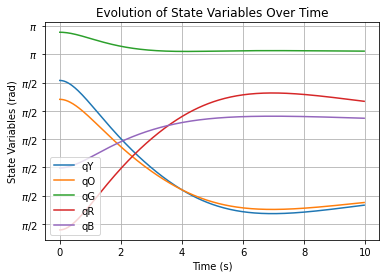

In [ ]:
plt.figure()
f,ax=plt.subplots(1)
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['y', 'orange', 'g', 'r', 'b']) +
                           cycler('linestyle', ['-', '-', '-', '-', '-'])))
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("State Variables (rad)")
artists = plt.plot(t,states[:,:5])
plt.title('Evolution of State Variables Over Time')

plt.legend(artists,['qY','qO','qG','qR','qB'])

# Function from https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
# Used to make tick marks show in units of pi
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(numpy.round(2 * value / numpy.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

# Makes the tick marks show units of pi
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

Prepare an animation of the mechanism's motion and show some of the frames

2021-03-20 05:12:05,866 - pynamics.output - INFO - calculating outputs
2021-03-20 05:12:05,887 - pynamics.output - INFO - done calculating outputs


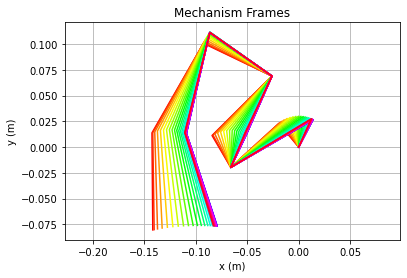

In [ ]:
# Make the colors make cycle through a large variety to show each frame
plt.rc('axes', prop_cycle=(plt.cycler('color', plt.cm.hsv(numpy.linspace(0, 1, fps)))))

points_output = PointsOutput(points,system)
y = points_output.calc(states)

points_output.plot_time(tfinal)
plt.title('Mechanism Frames')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

Plot the energy of the system

2021-03-20 05:12:06,243 - pynamics.output - INFO - calculating outputs
2021-03-20 05:12:06,261 - pynamics.output - INFO - done calculating outputs


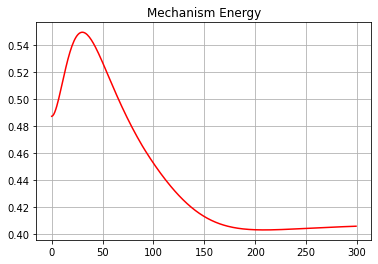

In [ ]:
KE = system.get_KE()
PE = system.getPEGravity(p0) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states)
energy_output.plot_time()
plt.title('Mechanism Energy')
plt.grid()

Plot an animation of the mechanism

In [ ]:
# Plots final frame of Animation and created object that is used for animation
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,1,1),linestyle='-') #produces animation using matplotlib
plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.close() # Hide the plot that just shows a single frame of the animation

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

**Note**: In the 10 second simulation, the leg does not move very far since the motor torque is relatively low (calculated based on the wind turbine experiment) and additionally the motor is turned off after 5 seconds in order to see the energy plot. We tested this with higher values for the motor torque and got similar results of the leg.

Creating a more easy to read animation (note: this code takes a long time to run. It creates an easier to understand animation, but does not provide any new information from the plot above)

In [ ]:
from matplotlib.animation import FuncAnimation

def animate(i):
    # Hacky way to not show show every frame (semitransparent whitebox colors over old frames)
    white = plt.fill([-0.2, -0.2, 0.05, 0.05], [ -0.1, 0.15, 0.15, -0.1], facecolor='white', alpha=0.3)
    # Blue link
    blueLink = plt.fill([y[i][7,0],  y[i][6,0],  y[i][5,0]], [ y[i][7,1],  y[i][6,1],  y[i][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Blue link
    blueLink = plt.fill([y[i][7,0],  y[i][6,0],  y[i][5,0]], [ y[i][7,1],  y[i][6,1],  y[i][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Purple link
    purpleLink = plt.fill([ y[i][0,0],  y[i][2,0],  y[i][4,0]], [ y[i][0,1],  y[i][2,1],  y[i][4,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
    # Red link
    redLink = plt.fill([ y[i][1,0],  y[i][3,0],  y[i][6,0]], [ y[i][1,1],  y[i][3,1],  y[i][6,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
    # Orange link
    orangeLink = plt.fill([ y[i][2,0],  y[i][3,0]], [ y[i][2,1],  y[i][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
    # Green link
    greenLink = plt.fill([ y[i][4,0],  y[i][5,0]], [ y[i][4,1],  y[i][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
    # Yellow link
    yellowLink = plt.fill([ y[i][0,0],  y[i][1,0]], [ y[i][0,1],  y[i][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)
    plt.axis('scaled')
    
    return blueLink

fig, ax = plt.subplots()

plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

anim = FuncAnimation(fig, animate, frames=t.size, interval=tstep*1000, blit=True)
HTML(anim.to_html5_video())

Now, we wanted to see the effect of the system when the motor torque was increased to a higher value so we could see the full gait in the 10 second simulation.

In [ ]:
system.addforce(-4.98*N.z*on,wY)

f,ma = system.getdynamics()
#Solving for Acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

#insert code here, some code copied and pasted from pendulum example
tol = 1e-12
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]
# Note: important to input a valid initial condition
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

Plotting (higher motor torque)

In [ ]:
plt.figure()
f,ax=plt.subplots(1)
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['y', 'orange', 'g', 'r', 'b']) +
                           cycler('linestyle', ['-', '-', '-', '-', '-'])))
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("State Variables (rad)")
artists = plt.plot(t,states[:,:5])
plt.title('Evolution of State Variables Over Time')

plt.legend(artists,['qY','qO','qG','qR','qB'])

# Function from https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
# Used to make tick marks show in units of pi
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(numpy.round(2 * value / numpy.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

# Makes the tick marks show units of pi
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

In [ ]:
# Make the colors make cycle through a large variety to show each frame
plt.rc('axes', prop_cycle=(plt.cycler('color', plt.cm.hsv(numpy.linspace(0, 1, fps)))))

points_output = PointsOutput(points,system)
y = points_output.calc(states)

points_output.plot_time(tfinal)
plt.title('Mechanism Frames')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

In [ ]:
KE = system.get_KE()
PE = system.getPEGravity(p0) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states)
energy_output.plot_time()
plt.title('Mechanism Energy')
plt.grid()

In [ ]:
# Plots final frame of Animation and created object that is used for animation
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,1,1),linestyle='-') #produces animation using matplotlib
plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.close() # Hide the plot that just shows a single frame of the animation

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

Note that the motor is still turned off after 5 seconds.

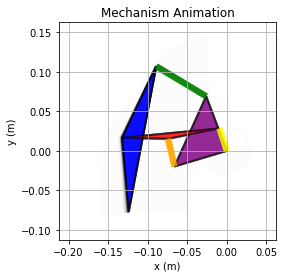

In [ ]:
from matplotlib.animation import FuncAnimation

def animate(i):
    # Hacky way to not show show every frame (semitransparent whitebox colors over old frames)
    white = plt.fill([-0.2, -0.2, 0.05, 0.05], [ -0.1, 0.15, 0.15, -0.1], facecolor='white', alpha=0.3)
    # Blue link
    blueLink = plt.fill([y[i][7,0],  y[i][6,0],  y[i][5,0]], [ y[i][7,1],  y[i][6,1],  y[i][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Blue link
    blueLink = plt.fill([y[i][7,0],  y[i][6,0],  y[i][5,0]], [ y[i][7,1],  y[i][6,1],  y[i][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Purple link
    purpleLink = plt.fill([ y[i][0,0],  y[i][2,0],  y[i][4,0]], [ y[i][0,1],  y[i][2,1],  y[i][4,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
    # Red link
    redLink = plt.fill([ y[i][1,0],  y[i][3,0],  y[i][6,0]], [ y[i][1,1],  y[i][3,1],  y[i][6,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
    # Orange link
    orangeLink = plt.fill([ y[i][2,0],  y[i][3,0]], [ y[i][2,1],  y[i][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
    # Green link
    greenLink = plt.fill([ y[i][4,0],  y[i][5,0]], [ y[i][4,1],  y[i][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
    # Yellow link
    yellowLink = plt.fill([ y[i][0,0],  y[i][1,0]], [ y[i][0,1],  y[i][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)
    plt.axis('scaled')
    
    return blueLink

fig, ax = plt.subplots()

plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

anim = FuncAnimation(fig, animate, frames=t.size, interval=tstep*1000, blit=True)
HTML(anim.to_html5_video())